# OLS Emulator Development

- This script is used to get the linear emulators for 
  - $\chi_\rm{a}$ (chi_abd) 
  - $\chi_\rm{h}$ (chi_hyg)
  - $\chi_\rm{o}$ (chi_opt1)
  - $\chi_\rm{bd}$ (chi_opt2, will be used in another paper)

In [1]:
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import gc
import statsmodels.api as sm


# Calculate squared_error
def squared_error(y_ori,y_pred):
    return np.sum((y_pred - y_ori) * (y_pred - y_ori))

# Calculate coefficient of determination
def coefficient_of_determination(y_ori,y_pred):
    """
    ref: https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    y_mean_pred = np.full(np.asarray(y_ori).shape, np.mean(y_ori)) 
    SSres = squared_error(y_ori, y_pred)
    SStot = squared_error(y_ori, y_mean_pred)
    return 1 - (SSres/SStot)

# Calculate index of agreement
def index_agreement(ori,pred):
    """
    ref: https://www.rforge.net/doc/packages/hydroGOF/d.html
    index of agreement
    input:
        pred: simulated
        ori: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((ori-pred)**2))/(np.sum(
        (np.abs(pred-np.mean(ori))+np.abs(ori-np.mean(ori)))**2))
    return ia


    
def ml_workflow(df_train, df_test, features_ls, pred):
    #X_train, X_test, y_train, y_test = train_test_split(df[features_ls], df[pred], test_size=0.1)
    X_train = df_train[features_ls]
    y_train = df_train[pred]
    X_test = df_test[features_ls]
    Y_ref = df_test[pred]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_new = scaler.transform(X_train)
    X_test_new = scaler.transform(X_test)
    
    # Get the models
    #reg = LinearRegression().fit(X_train, y_train)
    
    X2 = sm.add_constant(X_train_new)
    reg = sm.OLS(y_train, X2).fit()
    #print(reg.summary())
    
    # Evaluate the models
    X_test2 = sm.add_constant(X_test_new)
    df_predictions = reg.predict(X_test2)
    plt.figure(figsize=(10,10))
    plt.scatter(df_predictions,Y_ref,s = 6,color="purple",alpha=0.5)
    plt.plot([0,1],[0,1],color="red",alpha=0.6)
    #plt.title("Predicted om vs Actual om")
    plt.ylabel("Reference",fontsize=20)
    plt.xlabel("Prediction",fontsize=20)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    print('The cc is:',
          "{0:.3f}".format(np.corrcoef(np.asarray(Y_ref),np.asarray(df_predictions))[0][1]))
    print('The coefficient of determination is:',
          "{0:.3f}".format(coefficient_of_determination(Y_ref,df_predictions)))
    print('The coefficient of determination (Using sklearn) is:', 
          "{0:.3f}".format(metrics.r2_score(Y_ref, df_predictions)))
    print('The index of agreement is:',
          "{0:.3f}".format(index_agreement(Y_ref,df_predictions)))
    print('The root mean squared error is:', 
          "{0:.3f}".format(np.sqrt(mean_squared_error(Y_ref, df_predictions))))
    print('The mean absolute error is:', 
          "{0:.3f}".format(metrics.mean_absolute_error(Y_ref, df_predictions)))
    print('The median absolute error is:', 
          "{0:.3f}".format(metrics.median_absolute_error(Y_ref, df_predictions)))
    
    pickle.dump(reg, open("./linear_model/"+pred+".dat","wb"))
    
    del reg
    gc.collect()
    print("************************************")

In [2]:
vari = ["DMS_SRF","H2O2_SRF","H2SO4_SRF","O3_SRF","SO2_SRF","SOAG_SRF",
        'Mass_so4','Mass_bc','Mass_ncl','Mass_dst','Mass_pom','Mass_soa',
        "T", "RELHUM", "SZA"]
ms = ['chi_abd','chi_opt1','chi_opt2','chi_hyg']
vari_ms = vari+ms

case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/test_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/test_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_test_ori = pd.concat(case_ls)
#df_test.describe()


case_ensemble = {}
case_ls = []
for i in range(1,5):
    case_ensemble["case_"+str(i)] = pd.read_csv("../data/train_"+str(i)+".csv")
    case_ls.append(pd.read_csv("../data/train_"+str(i)+".csv"))
case_describe = {}
case_describe["case_1"] = "sea salt and dust" 
case_describe["case_2"] = "dust"
case_describe["case_3"] = "sea salt"
case_describe["case_4"] = "none"

df_train_ori = pd.concat(case_ls)
#df_train.describe()

chi_abd


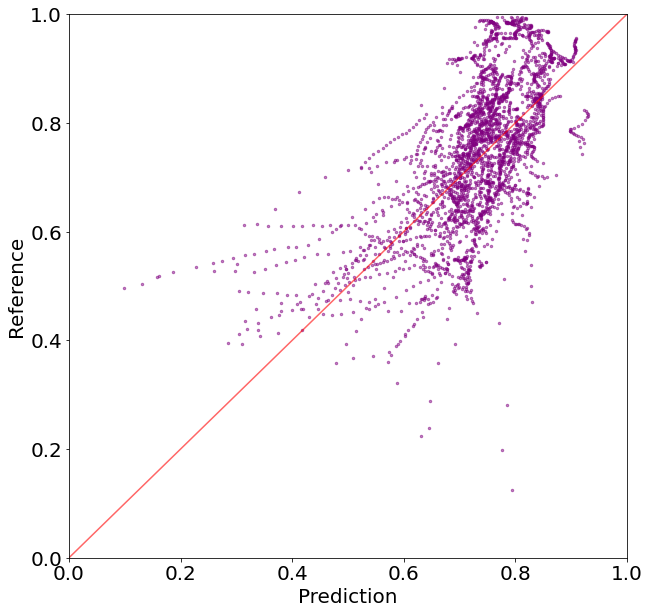

The cc is: 0.642
The coefficient of determination is: 0.395
The coefficient of determination (Using sklearn) is: 0.395
The index of agreement is: 0.767
The root mean squared error is: 0.107
The mean absolute error is: 0.084
The median absolute error is: 0.067
************************************
chi_opt1


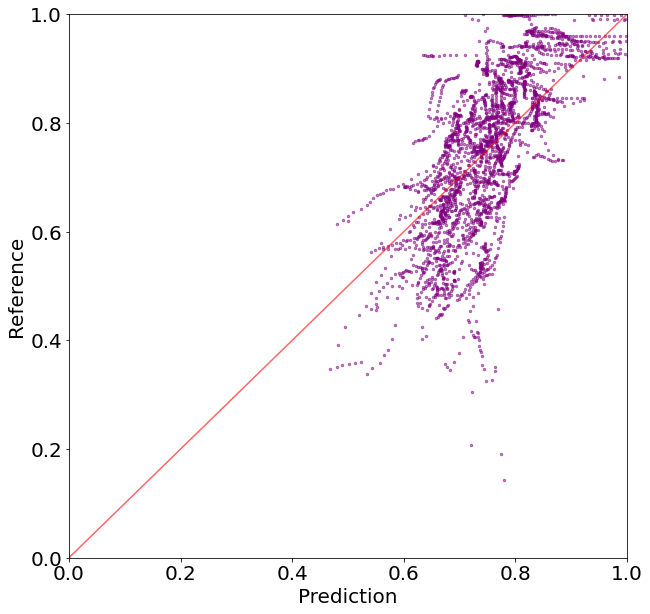

The cc is: 0.673
The coefficient of determination is: 0.452
The coefficient of determination (Using sklearn) is: 0.452
The index of agreement is: 0.779
The root mean squared error is: 0.109
The mean absolute error is: 0.085
The median absolute error is: 0.073
************************************
chi_opt2


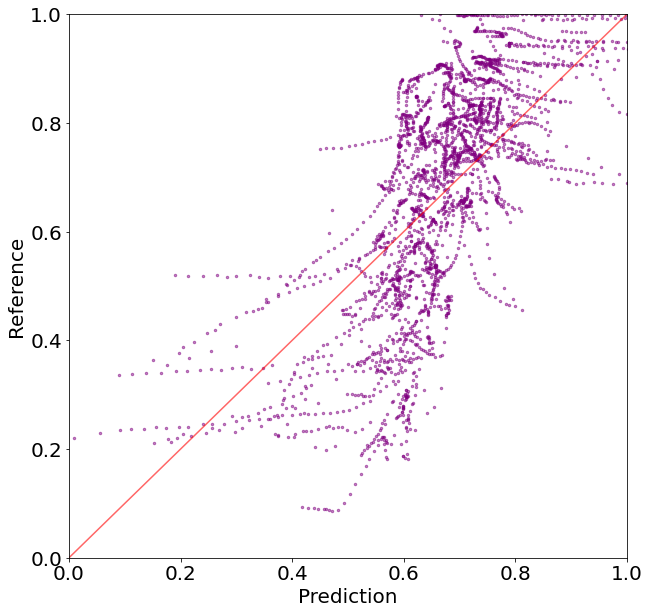

The cc is: 0.686
The coefficient of determination is: 0.470
The coefficient of determination (Using sklearn) is: 0.470
The index of agreement is: 0.788
The root mean squared error is: 0.152
The mean absolute error is: 0.124
The median absolute error is: 0.109
************************************
chi_hyg


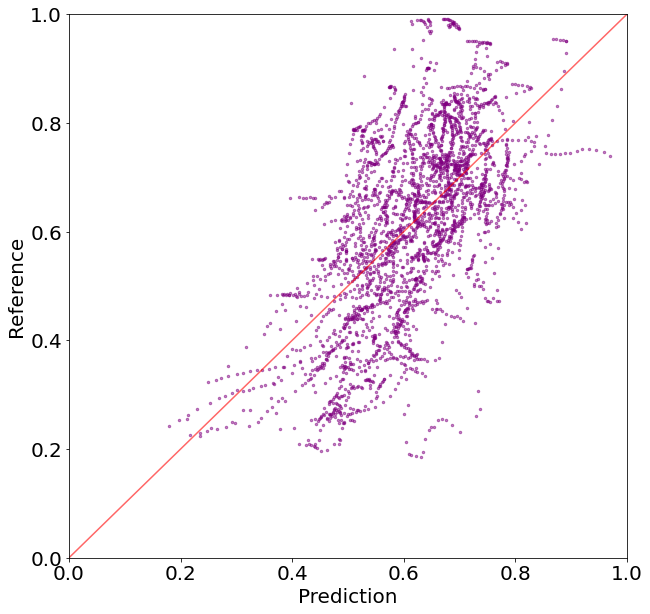

The cc is: 0.618
The coefficient of determination is: 0.382
The coefficient of determination (Using sklearn) is: 0.382
The index of agreement is: 0.731
The root mean squared error is: 0.134
The mean absolute error is: 0.107
The median absolute error is: 0.088
************************************


In [3]:
for i in range(4):
    print(ms[i])
    ml_workflow(df_train=df_train_ori.dropna(), df_test=df_test_ori.dropna(), features_ls=vari, pred=ms[i])